# UNet/FPN Fastai

* The entire operation into fastai lib

In [1]:
from pathlib import Path
DATA = DATA = Path('/home/paperspace/ssdd')

In [2]:
BS = 6
#LR_MIN = 1e-4
#LR_MAX = 3e-4
EPOCHS = 40
MODEL_NAME = "efficientnet-b3"
REMARK = "_"
THRESHOLD = 0.5
# cut to 400*4?
CUT_HORI = True
FP16 = True

MODEL_PTH = "ssdd_%s_b%s%s.pth"%(MODEL_NAME,BS,REMARK)

Choices of model names

### VGG
vgg11, vgg13, vgg16, vgg19, vgg11bn, vgg13bn, vgg16bn, vgg19bn,
### Densenet
densenet121, densenet169, densenet201, densenet161, dpn68, dpn98, dpn131,
### Resnet
inceptionresnetv2,
resnet18, resnet34, resnet50, resnet101, resnet152,
resnext50_32x4d, resnext101_32x8d,
### SeNet
se_resnet50, se_resnet101, se_resnet152,
se_resnext50_32x4d, se_resnext101_32x4d,
senet154,
#### EfficientNet
efficientnet-b0, efficientnet-b1, efficientnet-b2, efficientnet-b3, efficientnet-b4, efficientnet-b5, efficientnet-b6, efficientnet-b7


In [3]:
import segmentation_models_pytorch as smp

In [4]:
import os
import cv2
import pdb
import time
import warnings
import random
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm

from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader, Dataset, sampler

from matplotlib import pyplot as plt

from albumentations import (HorizontalFlip, RGBShift, ElasticTransform, GridDistortion,RandomBrightness ,ShiftScaleRotate, Normalize, Resize, Compose, GaussNoise)
from albumentations.pytorch import ToTensor

from onecyclelr import OneCycleLR

from sklearn.model_selection import train_test_split
from sklearn import model_selection
from fastai.vision import *

from ranger import Ranger

In [5]:
seed = 69
random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

### RLE-Mask utility functions

In [6]:
def mask2rle(img):
    '''
    Numpy image to run length encoding
    img: numpy array, 1 -> mask, 0 -> background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def make_mask(row_id, df):
    '''Given a row index, return image_id and mask (256, 1600, 4) from the dataframe `df`'''
    fname = df.iloc[row_id].name
    labels = df.iloc[row_id][:4]
    masks = np.zeros((256, 1600, 4), dtype=np.float32) # float32 is V.Imp
    # 4:class 1～4 (ch:0～3)

    for idx, label in enumerate(labels.values):
        if label is not np.nan:
            label = label.split(" ")
            positions = map(int, label[0::2])
            length = map(int, label[1::2])
            mask = np.zeros(256 * 1600, dtype=np.uint8)
            for pos, le in zip(positions, length):
                mask[pos:(pos + le)] = 1
            masks[:, :, idx] = mask.reshape(256, 1600, order='F')
    return fname, masks

### DataLoader

In [7]:
import fastai

In [8]:

def cutHorizontal(x):
    return torch.cat(list(x[...,i*400:(i+1)*400] for i in range(4)), dim=0)

def to416(x):
    size = list(x.size())
    size[-1]=416
    new = torch.zeros(size)
    new[...,8:-8] = x
    return new

class SteelDataset(Dataset):
    def __init__(self, df, data_folder, mean, std, phase):
        self.df = df
        self.root = data_folder
        self.mean = mean
        self.std = std
        self.phase = phase
        self.transforms = get_transforms(phase, mean, std)
        self.fnames = self.df.index.tolist()

    def __getitem__(self, idx):
        image_id, mask = make_mask(idx, self.df)
        image_path = os.path.join(self.root, "train_images",  image_id)
        img = cv2.imread(image_path)
        augmented = self.transforms(image=img, mask=mask)
        img = augmented['image'] # 1x256x1600
        mask = augmented['mask'] # 1x256x1600x4
        mask = mask[0].permute(2, 0, 1) # 1x4x256x1600
        return img, mask

    def __len__(self):
        return len(self.fnames)
        


def get_transforms(phase, mean, std):
    list_transforms = []
    if phase == "train":
        list_transforms.extend(
            [
                HorizontalFlip(p=0.5), # only horizontal flip as of now
                ShiftScaleRotate(scale_limit=0, rotate_limit=0),
                ElasticTransform(),
                GridDistortion(), 
                RandomBrightness(),
            ]
        )
    list_transforms.extend(
        [
            Normalize(mean=mean, std=std, p=1),
            ToTensor(),
        ]
    )
    list_trfms = Compose(list_transforms)
    return list_trfms

def provider(
    data_folder,
    df_path,
    mean=None,
    std=None,
    batch_size=BS,
    num_workers=8,
):
    '''Returns dataloader for the model training'''
    df = pd.read_csv(df_path)
    # https://www.kaggle.com/amanooo/defect-detection-starter-u-net
    df['ImageId'], df['ClassId'] = zip(*df['ImageId_ClassId'].str.split('_'))
    df['ClassId'] = df['ClassId'].astype(int)
    df = df.pivot(index='ImageId',columns='ClassId',values='EncodedPixels')
    df['defects'] = df.count(axis=1)
    
    train_df, val_df = train_test_split(df, test_size=0.2, stratify=df["defects"], random_state=69)
#     df = train_df if phase == "train" else val_df
    train_ds = SteelDataset(train_df, data_folder, mean, std, "train")
    val_ds  =SteelDataset(val_df, data_folder, mean,std, "val")
    databunch = DataBunch.create(train_ds,val_ds,path = data_folder,bs=BS,num_workers=num_workers)

    return databunch

In [9]:
data = provider(
    data_folder=DATA,
                df_path=DATA/"train.csv",
                mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225),
                batch_size=BS,
                num_workers=6,
)

In [10]:
x,y = data.one_batch()

In [11]:
x.size(),y.size()

(torch.Size([6, 3, 256, 1600]), torch.Size([6, 4, 256, 1600]))

### Utility function

#### Dice and IoU metric implementations, metric logger for training and validation.

In [12]:
def metricSeg(probability, truth, threshold=THRESHOLD, reduction='none'):
    '''Calculates dice of positive and negative images seperately'''
    '''probability and truth must be torch tensors'''
    probability = torch.sigmoid(probability)
    batch_size = len(truth)
    with torch.no_grad():
        probability = probability.view(batch_size, -1)
        truth = truth.view(batch_size, -1)
        assert(probability.shape == truth.shape)

        p = (probability > threshold).float()
        t = (truth > threshold).float()

        t_sum = t.sum(-1)
        p_sum = p.sum(-1)
        neg_index = torch.nonzero(t_sum == 0)
        pos_index = torch.nonzero(t_sum >= 1)

        dice_neg = (p_sum == 0).float()
        dice_pos = 2 * (p*t).sum(-1)/((p+t).sum(-1))

        dice_neg = dice_neg[neg_index]
        dice_pos = dice_pos[pos_index]
        dice = torch.cat([dice_pos, dice_neg])

        dice_neg = np.nan_to_num(dice_neg.mean().item(), 0)
        dice_pos = np.nan_to_num(dice_pos.mean().item(), 0)
        dice = dice.mean().item()

        num_neg = len(neg_index)
        num_pos = len(pos_index)

    return dice, dice_neg, dice_pos, num_neg, num_pos

class dices(LearnerCallback):
    _order = -20 # Needs to run before the recorder, very CRITICAL step
    def __init__(self,learn):
        super().__init__(learn)
        
    def on_train_begin(self,**kwargs):
        self.learn.recorder.add_metric_names(['dice','dice_neg','dice_pos','num_neg','num_pos'])
        
    def on_epoch_begin(self,**kwargs):
        self.ttl_dice = []
        self.ttl_dice_neg = []
        self.ttl_dice_pos = []
        self.ttl_num_neg = []
        self.ttl_num_pos = []
        self.ttl_lists = [self.ttl_dice,self.ttl_dice_neg,self.ttl_dice_pos,self.ttl_num_neg,self.ttl_num_pos]
    
    def on_batch_end(self,last_output,last_target,**kwargs):
        dice, dice_neg, dice_pos, num_neg, num_pos = metricSeg(last_output,last_target)
        self.ttl_dice.append(dice)
        self.ttl_dice_neg.append(dice_neg)
        self.ttl_dice_pos.append(dice_pos)
        self.ttl_num_neg.append(num_neg)
        self.ttl_num_pos.append(num_pos)
    
    def on_epoch_end(self,last_metrics,**kwargs):
        extras = [sum(i)/float(len(i)) for i in self.ttl_lists]
#         print(extras)
        return add_metrics(last_metrics, extras)
    
class cutHorizonCallback(Callback):
    def __init__(self):
        super().__init__()
        
    def on_batch_begin(self, last_input, last_target,**kwargs):
        last_input = to416(cutHorizontal(last_input))
        last_target = to416(cutHorizontal(last_target))



### Define Model

In [13]:
model = smp.FPN(MODEL_NAME, encoder_weights="imagenet", classes=4, activation=None).cuda()

In [14]:
model.encoder

EfficientNetEncoder(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        40, 40, kernel_size=(3, 3), stride=[1, 1], groups=40, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        40, 10, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        10, 40, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        40, 24, ker

### Fastai Learner

set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


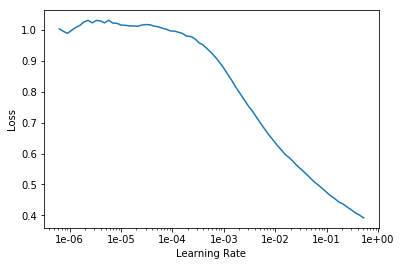

In [15]:
learn = Learner(data, model, metrics = [], opt_func=Ranger, loss_func = nn.BCEWithLogitsLoss(),callback_fns = dices).to_fp16()
learn.path = Path("./fastai")
learn.lr_find()
learn.recorder.plot()

In [16]:
from fastai.callbacks import SaveModelCallback

In [18]:
learn.fit_one_cycle(50,1e-3, callbacks=[
#                                         dices(learn),
                                       cutHorizonCallback(),
                                       SaveModelCallback(learn, every='epoch', monitor='loss')])

epoch,train_loss,valid_loss,dice,dice_neg,dice_pos,num_neg,num_pos,time


KeyboardInterrupt: 